In [ ]:
import pandas as pd
import numpy as np
import re
import string
from bs4 import BeautifulSoup
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# First, upgrade numpy to the latest version
!pip install --upgrade numpy

# Then, force reinstall gensim to ensure it's compatible with the new numpy version
!pip install --force-reinstall gensim

# After executing the above commands, restart your kernel or runtime and try importing again
from gensim.models.fasttext import FastText
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import matplotlib.pyplot as plt


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [ ]:

# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:


df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


In [ ]:

# Preprocessing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

df['tokens'] = df['text'].apply(preprocess)


In [ ]:

# Train FastText embedding model
fasttext_model = FastText(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4, sg=1)


In [ ]:

# Average FastText embeddings for sentence-level representation
def sentence_vector(tokens):
    vectors = [fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_embed = np.array([sentence_vector(tokens) for tokens in df['tokens']])
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.2, random_state=42)



🔍 Tuning Logistic Regression...

✅ Best Params for Logistic Regression: {'model__C': 10, 'model__solver': 'lbfgs'}

📊 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       965
           1       0.82      0.67      0.74       150

    accuracy                           0.94      1115
   macro avg       0.89      0.83      0.85      1115
weighted avg       0.93      0.94      0.93      1115



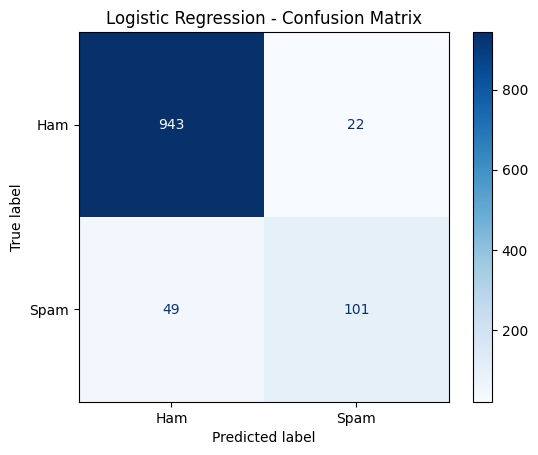


🔍 Tuning Random Forest...

✅ Best Params for Random Forest: {'model__max_depth': 20, 'model__n_estimators': 100}

📊 Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       965
           1       0.91      0.77      0.83       150

    accuracy                           0.96      1115
   macro avg       0.94      0.88      0.91      1115
weighted avg       0.96      0.96      0.96      1115



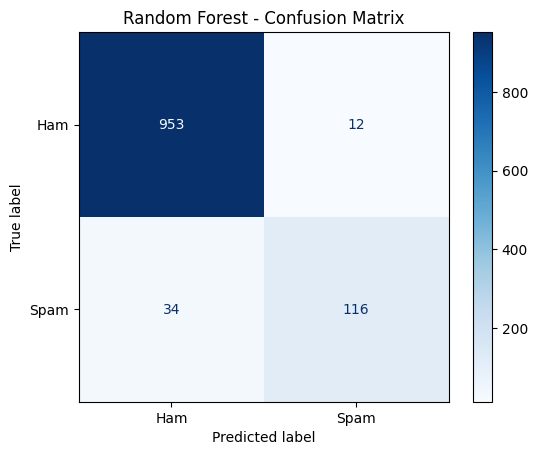


🔍 Tuning SVM...

✅ Best Params for SVM: {'model__C': 10, 'model__kernel': 'linear'}

📊 Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       965
           1       0.84      0.71      0.77       150

    accuracy                           0.94      1115
   macro avg       0.90      0.84      0.87      1115
weighted avg       0.94      0.94      0.94      1115



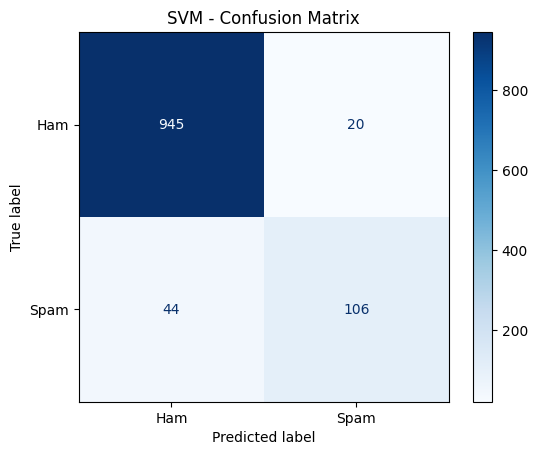

In [ ]:

# Improved ML model training with tuning
model_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'model__C': [0.1, 1, 10], 'model__solver': ['lbfgs']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear']}
    }
}

for name, config in model_grid.items():
    print(f"\n🔍 Tuning {name}...")
    pipeline = Pipeline([('model', config['model'])])
    grid = GridSearchCV(pipeline, config['params'], cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"\n✅ Best Params for {name}: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_test)

    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [ ]:

# Prepare data for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])
X_seq = pad_sequences(sequences, maxlen=50)
y_seq = df['label'].values
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)



In [ ]:
# Build embedding matrix for LSTM
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, idx in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[idx] = fasttext_model.wv[word]


In [ ]:

# LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                    input_length=50, trainable=False))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, validation_split=0.1)

loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"\n📊 LSTM Test Accuracy: {accuracy:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       788,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,000 (3.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 788,000 (3.01 MB)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9028 - loss: 0.2950 - val_accuracy: 0.9507 - val_loss: 0.1511
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9675 - loss: 0.1017 - val_accuracy: 0.9529 - val_loss: 0.1464
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9724 - loss: 0.0939 - val_accuracy: 0.9529 - val_loss: 0.1454
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9713 - loss: 0.0891 - val_accuracy: 0.9529 - val_loss: 0.1407
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9726 - loss: 0.0835 - val_accuracy: 0.9552 - val_loss: 0.1343
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9695 - loss: 0.0787

📊 LSTM Test Accuracy: 0.9686


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
def evaluate_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n📊 Evaluation for {name}:")
    print(f"  ✅ Accuracy:  {acc:.4f}")
    print(f"  ✅ Precision: {prec:.4f}")
    print(f"  ✅ Recall:    {rec:.4f}")
    print(f"  ✅ F1-score:  {f1:.4f}")



🔍 Tuning Logistic Regression...

✅ Best Params for Logistic Regression: {'model__C': 10, 'model__solver': 'lbfgs'}


<Figure size 1000x600 with 0 Axes>

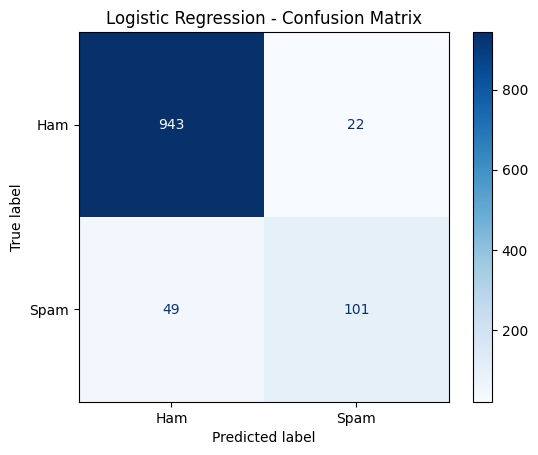


🔍 Tuning Random Forest...

✅ Best Params for Random Forest: {'model__max_depth': None, 'model__n_estimators': 200}


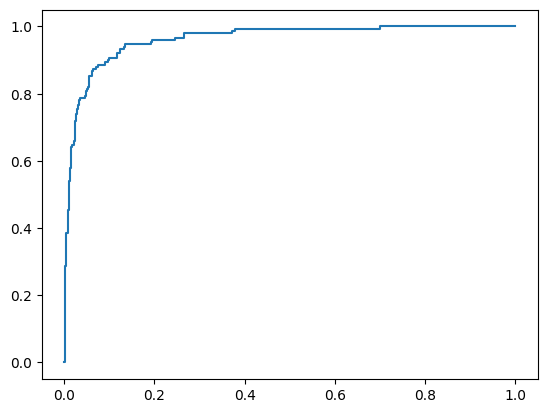

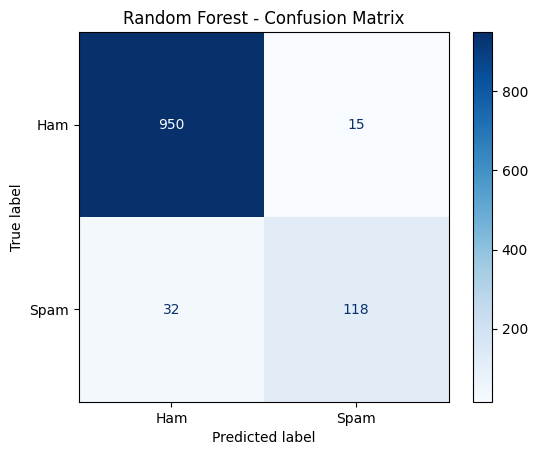


🔍 Tuning SVM...

✅ Best Params for SVM: {'model__C': 10, 'model__kernel': 'linear'}


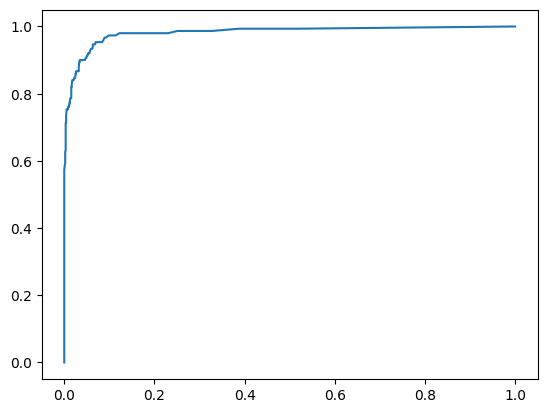

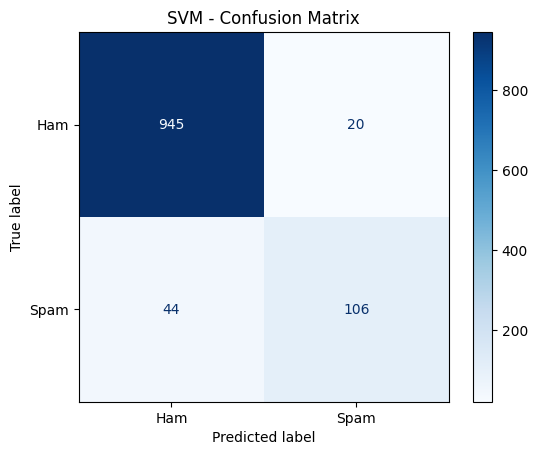

<ipython-input-28-dc6a793a1cf3>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


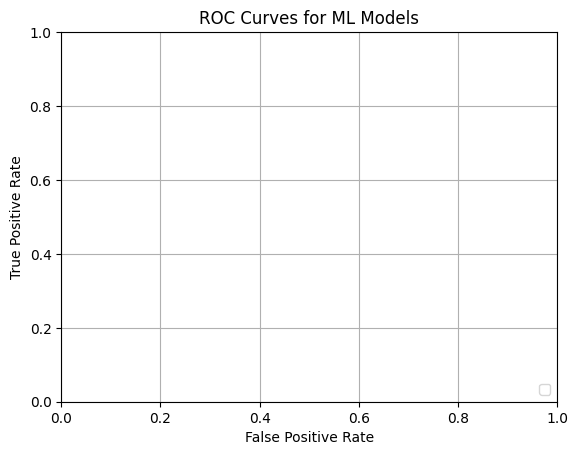

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


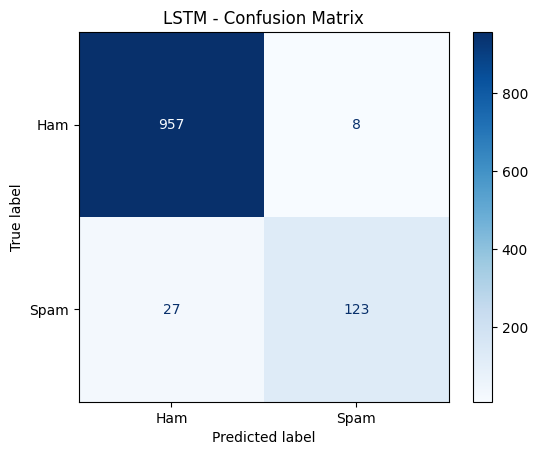

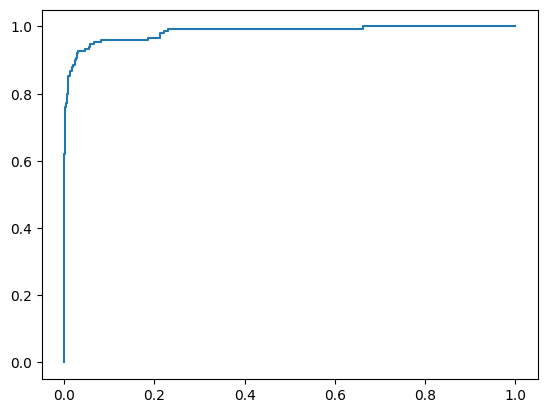

In [ ]:
# Confusion Matrix and ROC Curve plotting
def evaluate_model(name, y_true, y_pred, y_proba=None):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot ROC curves for ML models
plt.figure(figsize=(10, 6))

for name, config in model_grid.items():
    print(f"\n🔍 Tuning {name}...")
    pipeline = Pipeline([('model', config['model'])])
    grid = GridSearchCV(pipeline, config['params'], cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"\n✅ Best Params for {name}: {grid.best_params_}")

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    evaluate_model(name, y_test, y_pred, y_proba)

plt.title("ROC Curves for ML Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# LSTM Evaluation
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype("int32").flatten()
y_proba_lstm = model.predict(X_test_seq).flatten()

evaluate_model("LSTM", y_test_seq, y_pred_lstm, y_proba_lstm)
